In [1]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm


import matplotlib.pyplot as plt
plt.ion()

import scipy
from PIL import Image
from scipy import ndimage

    
    
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os, sys
from IPython.display import display
from IPython.display import Image as _Imgdis


# Set random seed
np.random.seed(0)

import h5py

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load data
train_dataset = h5py.File('train_catvnoncat.h5', "r")
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

test_dataset = h5py.File('test_catvnoncat.h5', "r")
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

classes = np.array(test_dataset["list_classes"][:]) # the list of classes
   
train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y_orig.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y_orig.shape))



# Look at some data
print(train_set_x_orig[0])
print(train_set_y_orig[0])

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)
[[[17 31 56]
  [22 33 59]
  [25 35 62]
  ...
  [ 1 28 57]
  [ 1 26 56]
  [ 1 22 51]]

 [[25 36 62]
  [28 38 64]
  [30 40 67]
  ...
  [ 1 27 56]
  [ 1 25 55]
  [ 2 21 51]]

 [[32 40 67]
  [34 42 69]
  [35 42 70]
  ...
  [ 1 25 55]
  [ 0 24 54]
  [ 1 21 51]]

 ...

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]]
[0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0
 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0

y = [0], it's a 'non-cat' picture.


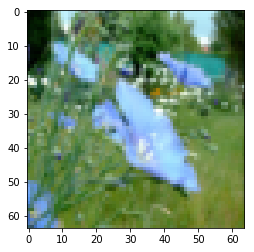

In [3]:
# Example of a picture
index = 20
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y_orig[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y_orig[:, index])].decode("utf-8") +  "' picture.")

In [4]:
# Reshape the training and test examples

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

#standardize our dataset
#see lab 1 notes for more info
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y_orig.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y_orig.shape))
print ("sanity check after reshaping: " + str(train_set_x[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [0.06666667 0.12156863 0.21960784 0.08627451 0.12941176]


In [5]:
sess = tf.InteractiveSession()

In [6]:
## Input pixels, flattened
X = tf.placeholder("float", [12288, None])
## Known labels
Y = tf.placeholder("float", [1, None])


# Variables
W1 = tf.get_variable("W1", [20,12288], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
b1 = tf.get_variable("b1", [20,1], initializer = tf.zeros_initializer())


W2 = tf.get_variable("W2", [7,20], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
b2 = tf.get_variable("b2", [7,1], initializer = tf.zeros_initializer())


W3 = tf.get_variable("W3", [5,7], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
b3 = tf.get_variable("b3", [5,1], initializer = tf.zeros_initializer())


W4 = tf.get_variable("W4", [1,5], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
b4 = tf.Variable(tf.zeros([1]))

# Just initialize
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [7]:
b1.eval()

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
# Just initialize
sess.run(tf.initialize_all_variables())

In [9]:
# Define model
Z1 = tf.add(tf.matmul(W1,X),b1)                                  # Z1 = np.dot(W1, X) + b1
A1 = tf.nn.relu(Z1)                                              # A1 = relu(Z1)

Z2 = tf.add(tf.matmul(W2,A1),b2)                                 
A2 = tf.nn.relu(Z2)                                              

Z3 = tf.add(tf.matmul(W3,A2),b3)                                 
A3 = tf.nn.relu(Z3)                                              

Z4 = tf.add(tf.matmul(W4,A3),b4)                                 
A4 = tf.sigmoid(Z4)

print ("X is: " + str(X.shape))
print ("Y is: " + str(Y.shape))
print ("W1 is: " + str(W1.shape))
print ("b1 is: " + str(b1.shape))
print ("Z1 is: " + str(Z1.shape))
print ("A1 is: " + str(A1.shape))

print ("W2 is: " + str(W2.shape))
print ("Z2 is: " + str(Z2.shape))

X is: (12288, ?)
Y is: (1, ?)
W1 is: (20, 12288)
b1 is: (20, 1)
Z1 is: (20, ?)
A1 is: (20, ?)
W2 is: (7, 20)
Z2 is: (7, ?)


In [10]:
# Cost function
#cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits = z,  labels = y)
cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits= Z4, labels= Y))
#OLD   cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits= z, labels= y)

# How we train (GradientDescent)
train_step = tf.train.GradientDescentOptimizer(0.02).minimize(cross_entropy)


In [11]:
# map CAT data to my TF template code
dataset = train_set_x
test_dataset = test_set_x  
y_train_vector = train_set_y_orig
y_test_vector = test_set_y_orig

print ("the shape of dataset is :" + str (dataset.shape))
print ("the shape of test_dataset is :" + str (test_dataset.shape))
print ("the shape of y_train_vector is :" + str (y_train_vector.shape))
print ("the shape of y_test_vector is :" + str (y_test_vector.shape))

the shape of dataset is :(12288, 209)
the shape of test_dataset is :(12288, 50)
the shape of y_train_vector is :(1, 209)
the shape of y_test_vector is :(1, 50)


In [12]:
# Actually train
epochs = 2400

print_cost = True
costs = []

# Actual Prediction
prediction = tf.round(tf.sigmoid(Z2))
predictions_correct = tf.cast(tf.equal(prediction, Y), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

train_acc = []
test_acc = []


#for i in tqdm(range(epochs)):
for i in range(0, epochs):
    train_step.run(feed_dict={X: dataset, Y: y_train_vector})
    
    temp_cost = sess.run(cross_entropy, feed_dict={X: dataset, Y: y_train_vector})
    costs.append(temp_cost)
    
    temp_acc_train = sess.run(accuracy, feed_dict={X: dataset, Y: y_train_vector})
    train_acc.append(temp_acc_train)
    
    temp_acc_test = sess.run(accuracy, feed_dict={X: test_dataset, Y: y_test_vector})
    test_acc.append(temp_acc_test)
    
    if i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(temp_cost)))
  

Cost after iteration 0: 0.7497527003288269
Cost after iteration 100: 0.5430137515068054
Cost after iteration 200: 0.5957576632499695
Cost after iteration 300: 0.35971400141716003
Cost after iteration 400: 0.2462081015110016
Cost after iteration 500: 0.19137026369571686
Cost after iteration 600: 0.13980607688426971
Cost after iteration 700: 0.07953321933746338
Cost after iteration 800: 0.6925799250602722
Cost after iteration 900: 0.051869843155145645
Cost after iteration 1000: 0.4096447229385376
Cost after iteration 1100: 0.28225794434547424
Cost after iteration 1200: 0.10389939695596695
Cost after iteration 1300: 0.3635541498661041
Cost after iteration 1400: 0.04191771522164345
Cost after iteration 1500: 0.027070434764027596
Cost after iteration 1600: 0.022393152117729187
Cost after iteration 1700: 0.019231807440519333
Cost after iteration 1800: 0.016210203990340233
Cost after iteration 1900: 0.014374619349837303
Cost after iteration 2000: 0.013180341571569443
Cost after iteration 2100

In [ ]:
# Plot loss over time
plt.plot(costs, 'k-')
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.show()

# Plot train and test accuracy
plt.plot(train_acc, 'k-', label='Train Set Accuracy')
plt.plot(test_acc, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
print (sess.run(accuracy, feed_dict={X: dataset, Y: y_train_vector}))
print (sess.run(accuracy, feed_dict={X: test_dataset, Y: y_test_vector}))

In [ ]:
W2.eval()

In [ ]:
print (costs)

In [ ]:
#Test Image 
#fname = "cat1.JPG"  #LR is good
#fname = "cat3.JPG"  #LR is bad
#fname = "cat4.JPG"  #LR is good
fname = "cartoon_grump.JPG"   #LR is bad
#fname = "puss.JPG"   #LR is bad
#fname = "meandog.JPG"  #LR is good
image = np.array(ndimage.imread(fname, flatten=False))
resized_image = scipy.misc.imresize(image, size=(64,64))
my_image = resized_image.reshape((1, 64*64*3)).T


print ("The Algo says " + str(A4.eval({X:my_image})))
print (Z4.eval({X:my_image}))
plt.imshow(image)
plt.show()
plt.imshow(resized_image)


#print (W)